<a href="https://colab.research.google.com/github/marinebon/HackingLimno2025/blob/main/01_obis_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taxonomic occurrence data from OBIS

## Setup

In [1]:
# Modify this section as needed.

# ==============================================================================
# === directory setup
# ==============================================================================
# === If using google colab and google drive:
# TODO: is there a way to do this without granting excessive permissions?
from google.colab import drive
drive.mount('/content/drive')

# NOTE: Before running you must create a folder in your google drive
#       matching the directory name here `GSoC_SDM_Project`.
PROJECT_DIR = '/content/drive/MyDrive/GSoC_SDM_Project'

# === if using local machine
# PROJECT_DIR = './'
#import os
#if not os.path.exists(PROJECT_DIR):
#    os.makedirs(PROJECT_DIR)
# ==============================================================================
# ==============================================================================
# === spatial coverage
# ==============================================================================
# # === FL
LATMIN = 24.0
LATMAX = 30.7
LONMIN = -87.9
LONMAX = -79.5
# === FL Keys
# LATMIN = 24.11637699635014
# LATMAX = 26.11949526731449
# LONMIN = -82.51572158798965
# LONMAX = -79.61106009492724
 ==============================================================================

Mounted at /content/drive


In [2]:
%pip -q install pyobis geoplot geopandas geodatasets

import pyobis
import geoplot
import geodatasets
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.5 MB/s eta 0:00:00


## Build a bounding box

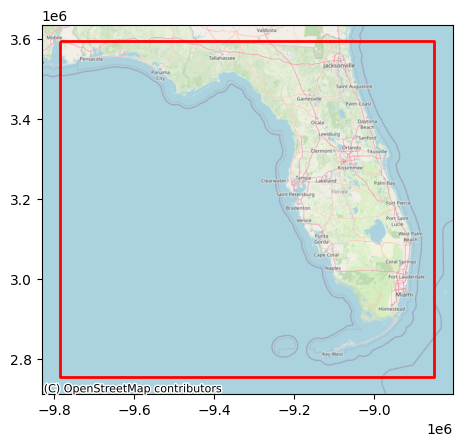

In [11]:
import geopandas
import contextily as ctx
import matplotlib.pyplot as plt

wkt = [f"POLYGON (({LONMIN} {LATMAX}, {LONMIN} {LATMIN}, {LONMAX} {LATMIN}, {LONMAX} {LATMAX}, {LONMIN} {LATMAX}))"]
gdf = geopandas.GeoSeries.from_wkt(wkt)

# Convert to GeoDataFrame and set CRS to WGS84
gdf_wsgs84 = geopandas.GeoDataFrame(geometry=gdf, crs="EPSG:4326")

# Convert to Web Mercator for plotting with basemap
gdf_webmerc = gdf_wsgs84.to_crs(epsg=3857)

# Plot
ax = gdf_webmerc.plot(facecolor='none', edgecolor='red', linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

In [13]:

from pyobis import occurrences
import pandas as pd
import os


# define depth range (in meters)
STARTDEPTH = 0
ENDDEPTH = 30
CACHE = True


# create empty df
df = pd.DataFrame()
# Lists of taxa IDs from Essential Ocean Variables
# ref: https://github.com/ioos/marine_life_data_network/blob/main/eov_taxonomy/IdentifierList.csv
taxa_ids = [143769, 143770, 143751, 143768, 234030]  # seagrasses
for taxa_id in taxa_ids:
    query = occurrences.search(taxonid=taxa_id, startdepth=STARTDEPTH, enddepth=ENDDEPTH, geometry=gdf.to_wkt()[0])
    df_taxa = query.execute()
    if len(df_taxa) < 1:
        continue
    else:
        # select only the columns we need
        df_taxa = df_taxa[["decimalLatitude", "decimalLongitude", "occurrenceStatus", "date_year", "date_mid"]]
        df = pd.concat([df, df_taxa], ignore_index=True)

print(f'nrecords: {len(df)}')

# save df
df.to_parquet(f'{PROJECT_DIR}/occurrences.parquet', engine='pyarrow', index=False)

print(df.head())

nrecords: 3436
   decimalLatitude  decimalLongitude occurrenceStatus  date_year      date_mid
0        25.138383        -80.624983                Q     2006.0  1.147133e+12
1        24.996280        -80.649250                Q     2006.0  1.160006e+12
2        25.248783        -80.403150                Q     2005.0  1.115683e+12
3        25.252020        -80.397290                Q     2007.0  1.189469e+12
4        25.472200        -80.325950                Q     2005.0  1.129680e+12


## visualization

### 1. year-wise distribution
Let us see the year-wise distribution of records.

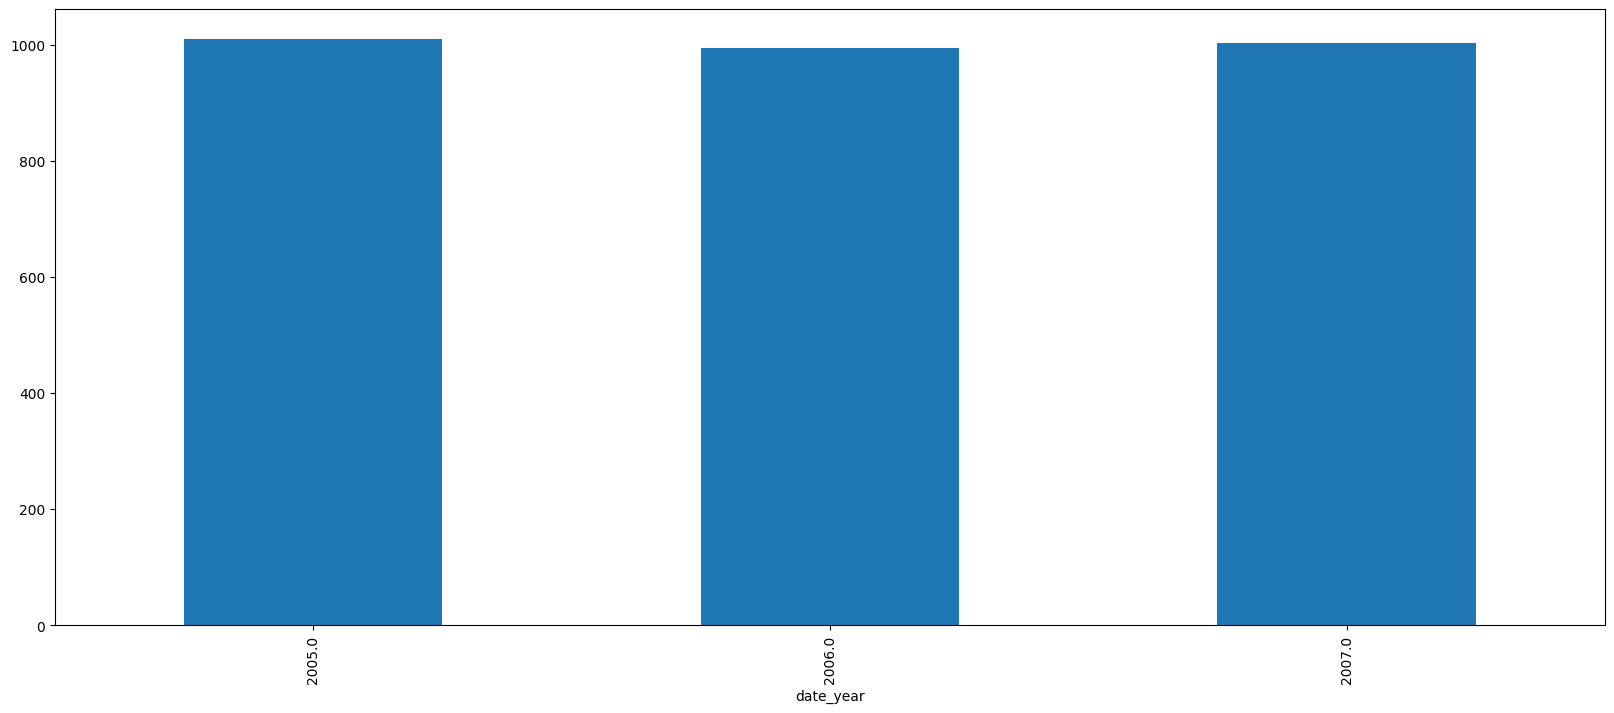

In [ ]:
df = pd.read_parquet(f'{PROJECT_DIR}/occurrences.parquet')

ax = df.groupby("date_year").date_mid.count().plot.bar(figsize = (20,8))

Patterns in the number of records through time are more likely due to sampling bias than changes in taxa population.

In [ ]:
import plotly.express as px


# Create a scatter plot on a map
fig = px.scatter_geo(
    df,
    lat='decimalLatitude',
    lon='decimalLongitude',
    #hover_name='station',
    projection='natural earth',
    title='Points on a Map',
)
fig.show()

--------------------
--------------------